### Predicting Heart Failure: Training ML Classifiers on Medical Data ###

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import pickle


In [3]:
# Read CSV file
parent_path = os.path.dirname(os.getcwd())
csv_path = os.path.join(parent_path, 'data/heart.csv')

df = pd.read_csv(csv_path)

df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


#### Exploratory Data Analysis #### 

In [5]:
# Summary Statistics
print(df.shape)

df.describe()

(918, 12)


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [9]:
# Check for missing values 
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [11]:
# Datatypes
df.dtypes.sort_values()

Age                 int64
RestingBP           int64
Cholesterol         int64
FastingBS           int64
MaxHR               int64
HeartDisease        int64
Oldpeak           float64
Sex                object
ChestPainType      object
RestingECG         object
ExerciseAngina     object
ST_Slope           object
dtype: object

#### Visualisations - Feature and Target Variables #### 

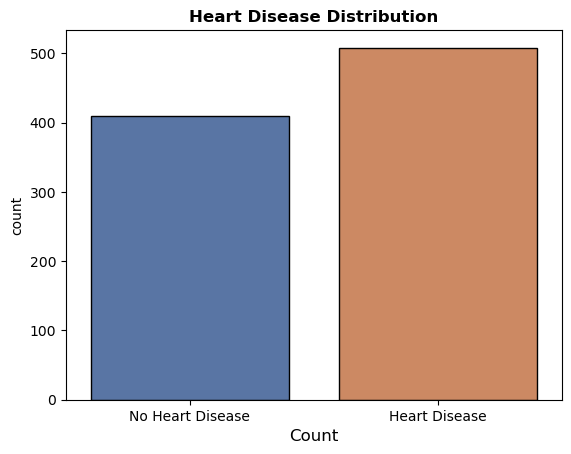

In [14]:
# Target Variable - Countplot
sns.countplot(x='HeartDisease', data=df, palette ='deep', edgecolor='black')
plt.title('Heart Disease Distribution', weight='bold')
plt.xlabel('Heart Disease', fontsize=12)
plt.xlabel('Count', fontsize=12)
plt.xticks([0, 1], ['No Heart Disease', 'Heart Disease'])
plt.show()

In [16]:
# Define a function to generate axes with a specified number of subplots
def get_custom_axes(figsize: list, rows: int, columns: int, subplots: list):
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(rows,columns)
    axes = [fig.add_subplot(gs[i]) for i in range(len(subplots))]
    return axes
    

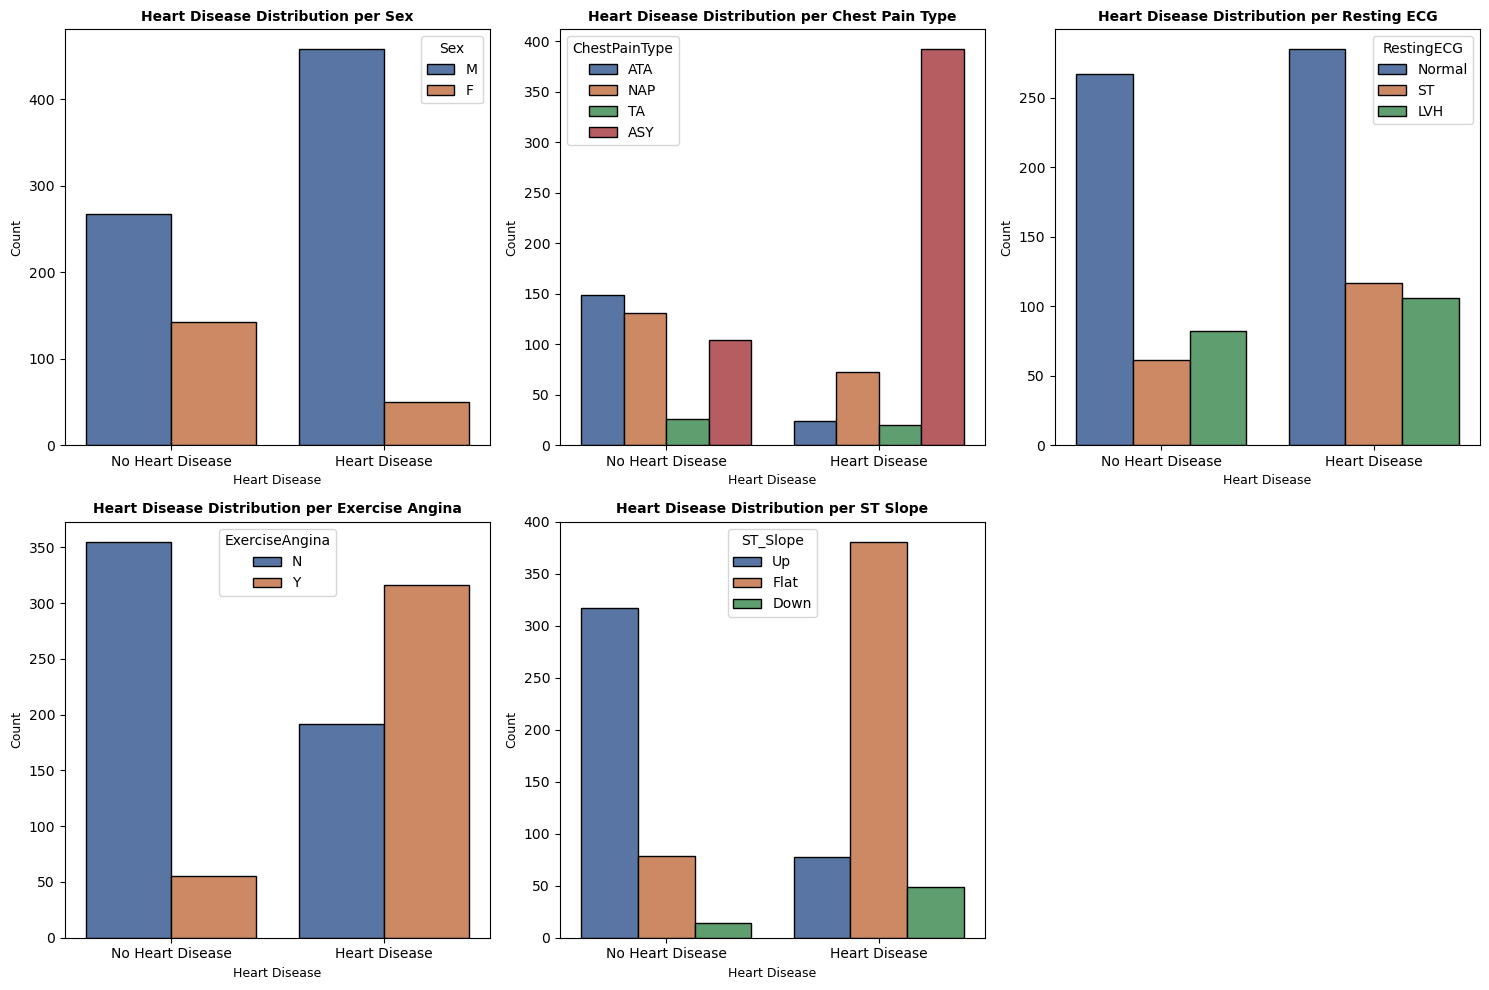

In [18]:
# Heart Disease Vs [Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope]
hue_vars = df.select_dtypes(include=['object']).columns

axes= get_custom_axes([15,10],2,3, hue_vars)

for i, hue_var in enumerate(hue_vars):
    sns.countplot(x='HeartDisease', data=df, hue=hue_var, ax = axes[i], edgecolor='black', palette ='deep')
    hue_var_title = ' '.join(re.findall(r'[A-Z][a-z]+|[A-Z]+', hue_var))
    axes[i].set_title(f'Heart Disease Distribution per {hue_var_title}', weight='bold', fontsize=10)
    axes[i].set_xlabel('Heart Disease', fontsize=9)
    axes[i].set_ylabel('Count', fontsize=9)
    axes[i].set_xticks([0, 1], ['No Heart Disease', 'Heart Disease'])



plt.tight_layout()
plt.show()


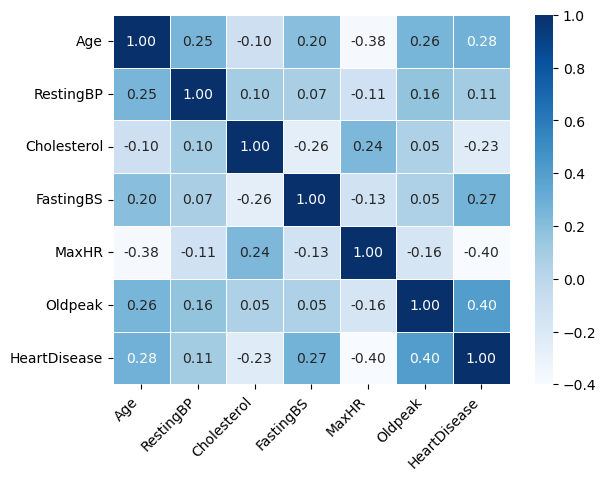

In [19]:
# Correlation between numerical variables - Plot correlation coefficient in a heatmap
corr_matrix = df.select_dtypes(include=[np.number]).corr()
fig = sns.heatmap(corr_matrix,annot=True, fmt=".2f", linewidth=.5, cmap='Blues')
fig.set_xticklabels(fig.get_xticklabels(),rotation=45, ha='right');

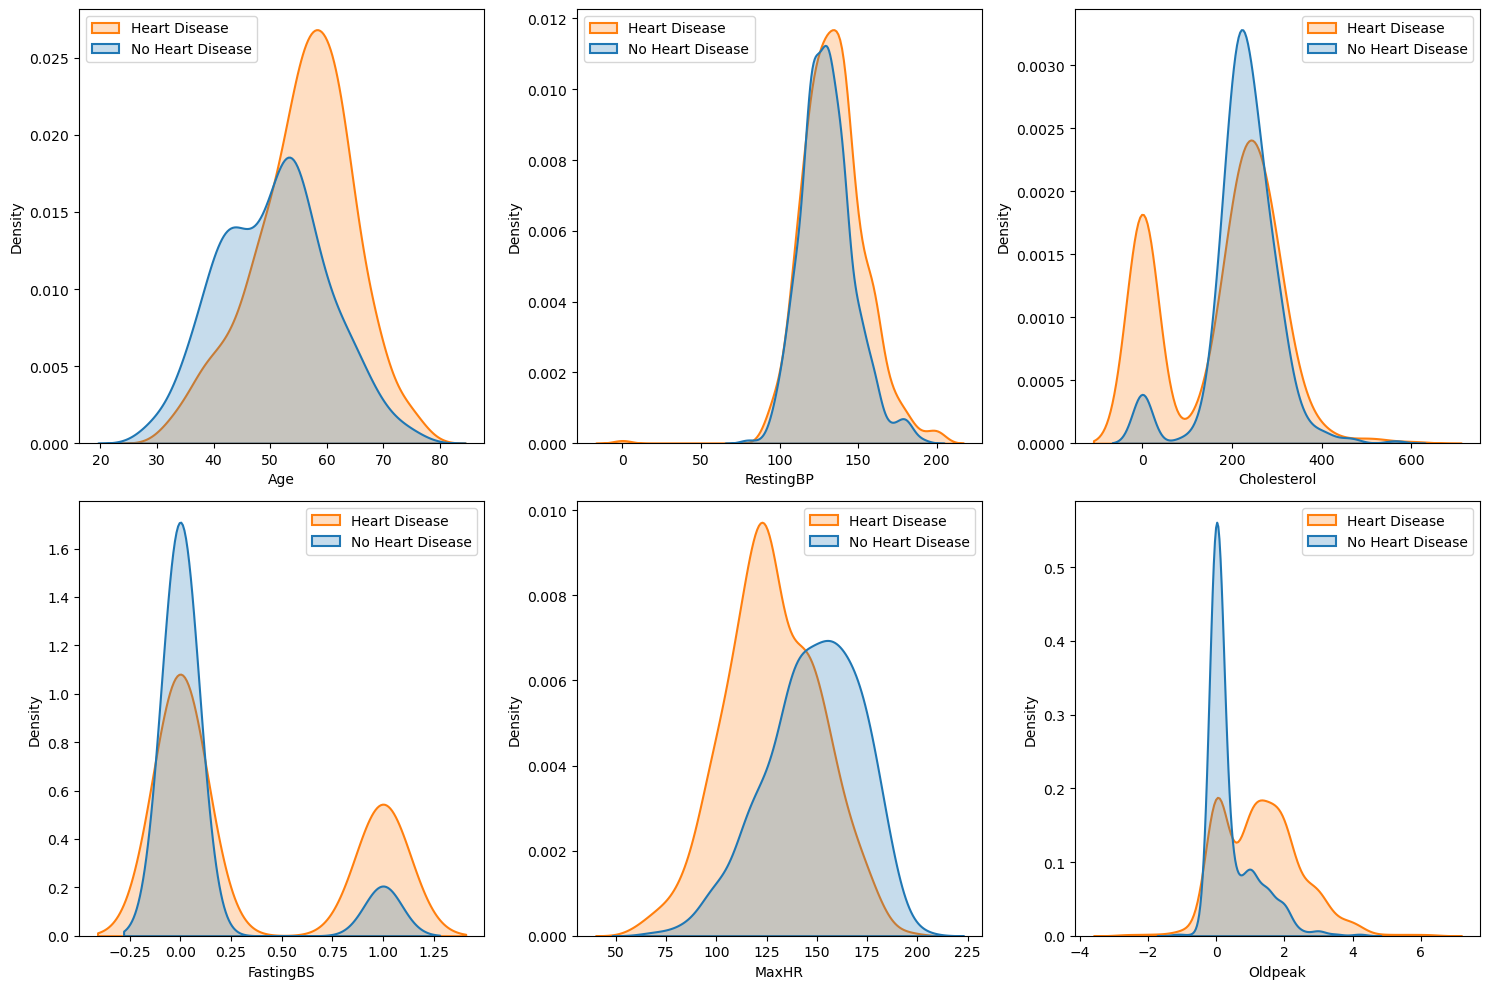

In [22]:
# KDE Plot - Heart Disease Vs [Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak]
hue_vars = df.select_dtypes(include=[np.number]).columns.drop('HeartDisease')

axes = get_custom_axes([15,10],2,3, hue_vars)

for i, hue_var in enumerate(hue_vars):
    sns.kdeplot(data=df, x=hue_var, hue='HeartDisease', ax = axes[i], linewidth=1.5, fill=True)
    axes[i].legend(labels=['Heart Disease', 'No Heart Disease'])

plt.tight_layout()
plt.show()

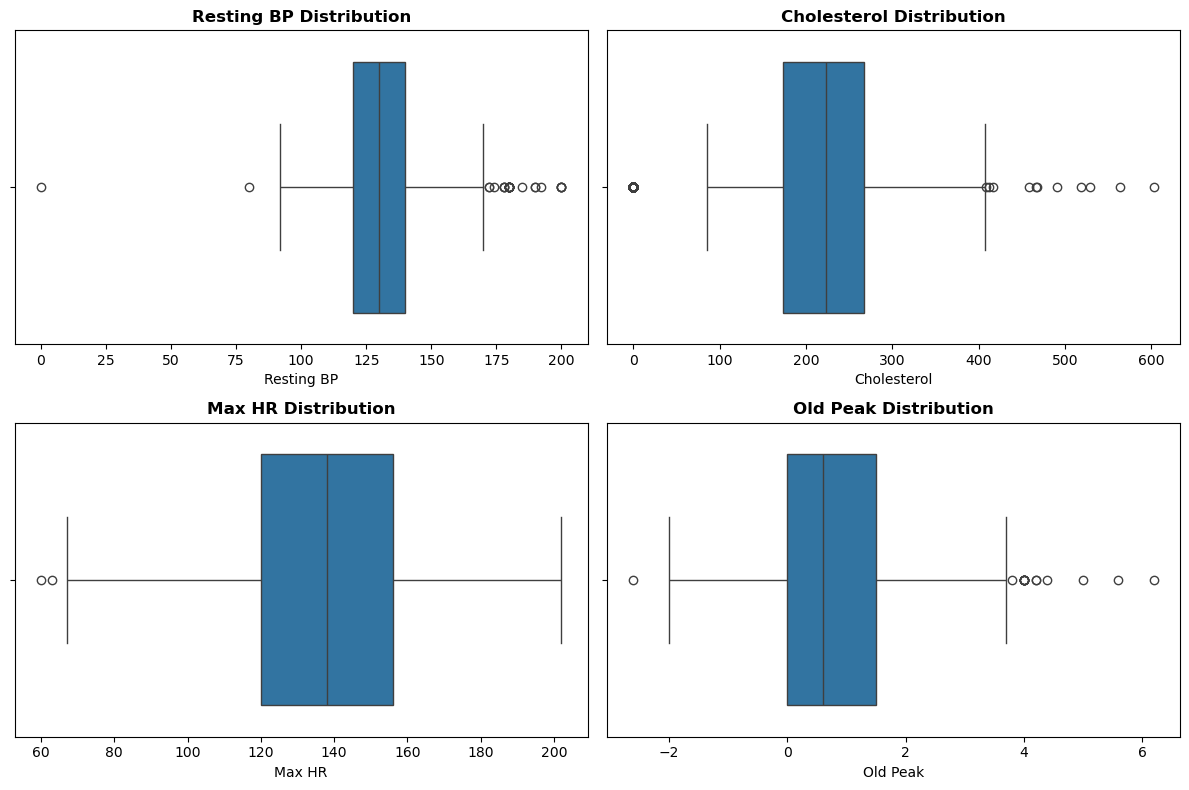

In [24]:
# Visualise the numerical variables using boxplots to identify any outliers.
plt.figure(figsize=[12,8])

plt.subplot(2,2,1)
base_colour= sns.color_palette()[0]
sns.boxplot(data=df, x= 'RestingBP', color=base_colour)
plt.title('Resting BP Distribution',fontweight='bold')
plt.xlabel('Resting BP')

plt.subplot(2,2,2)
sns.boxplot(data=df, x= 'Cholesterol', color=base_colour)
plt.title('Cholesterol Distribution',fontweight='bold')
plt.xlabel('Cholesterol')

plt.subplot(2,2,3)
sns.boxplot(data=df, x= 'MaxHR', color=base_colour)
plt.title('Max HR Distribution',fontweight='bold')
plt.xlabel('Max HR')

plt.subplot(2,2,4)
sns.boxplot(data=df, x= 'Oldpeak', color=base_colour)
plt.title('Old Peak Distribution', fontweight='bold')
plt.xlabel('Old Peak')

plt.tight_layout()


#### Model Building  ####

In [27]:
# Data Pre-processing
# Handling categorical variables - Apply one-hot encoding/label encoding to convert categorical variables into numerical format
# One Hot Encoding will be used for ChestPainType given its nominal/non-ordered nature. All other Binary/Ordinal variables will be encoded using LabelEncoder
# Use inverse_transform via the corresponding LabelEncoder (encoders - dictionary) to recover the original categorical values

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Train-Test Split: Split the data into training and testing sets
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# Split numerical and categorical variables ahead of processing 
cat_vars = df.select_dtypes(include='object').columns.drop('ChestPainType')
num_vars = ['RestingBP','Cholesterol','MaxHR','Oldpeak']

# Define preprocesing steps including encoding/scaling
preprocessor = ColumnTransformer(transformers=[('label_encoder', OrdinalEncoder(), cat_vars),
                                             ('one_hot_encoder', OneHotEncoder(sparse_output=False), ['ChestPainType']),
                                             ('robust_scaler', RobustScaler(), num_vars)], remainder='passthrough')

# Perform cross validation - Use the mean CV Score to evaluate the model's generalisation ability
models = {
    'LogisticRegression' : LogisticRegression(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'XGB': XGBClassifier(random_state=42,objective='binary:logistic')}

for model, classifier in models.items():
    # Construct pipeline for each classifier
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', classifier)])

    # Perform 5-fold cross-validaiton on the training data
    scores = cross_val_score(pipeline, X_train, y_train, cv=5)
    print(f"{model} - Mean CV Score: {scores.mean()}")

                                             

LogisticRegression - Mean CV Score: 0.8528468921815302
RandomForestClassifier - Mean CV Score: 0.871941105209207
SVM - Mean CV Score: 0.6989190196626596
XGB - Mean CV Score: 0.8501630789302022


#### Model Evaluation  ####

In [30]:
# Model Selection: Random Forest Classifier - Highest mean cross-validation score
# Perform hyperparameter tuning to further optimise the Random Forest Model before evaluating the model on the test data

param_grid = {
    'model__n_estimators': list(range(50, 300, 50)),
    'model__max_features': ['auto', 'sqrt', 'log2'],
    'model__max_depth': ['None', 3,5,7,10],
    'model__min_samples_split' : list(range(2,10,2)),
    'model__min_samples_leaf' : list(range(2,10,2)),
    'model__bootstrap': [True, False]}

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', models['RandomForestClassifier'])])

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit Grid search/Perform cross validation and train the model with best hyperparameters on the entire training dataset
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('label_encoder',
                                                                         OrdinalEncoder(),
                                                                         Index(['Sex', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')),
                                                                        ('one_hot_encoder',
                                                                         OneHotEncoder(sparse_output=False),
                                                                         ['ChestPainType']),
                                                                        ('robust_scaler',
                                                                         RobustScaler(),
                                                                         ['RestingBP',
                                                                          'Cholesterol',
                                                                          'MaxHR',
                                                                          'Oldpeak'])])),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__bootstrap': [True, False],
                         'model__max_depth': ['None', 3, 5, 7, 10],
                         'model__max_features': ['auto', 'sqrt', 'log2'],
                         'model__min_samples_leaf': [2, 4, 6, 8],
                         'model__min_samples_split': [2, 4, 6, 8],
                         'model__n_estimators': [50, 100, 150, 200, 250]},
             verbose=1)

In [32]:
# Best Hyperparameters
print(grid_search.best_params_)
# Optimal Model 
optimal_model = grid_search.best_estimator_

{'model__bootstrap': True, 'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 6, 'model__n_estimators': 100}


In [34]:
# Evaluate model using the test data
y_pred = optimal_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88        77
           1       0.92      0.90      0.91       107

    accuracy                           0.90       184
   macro avg       0.89      0.90      0.89       184
weighted avg       0.90      0.90      0.90       184



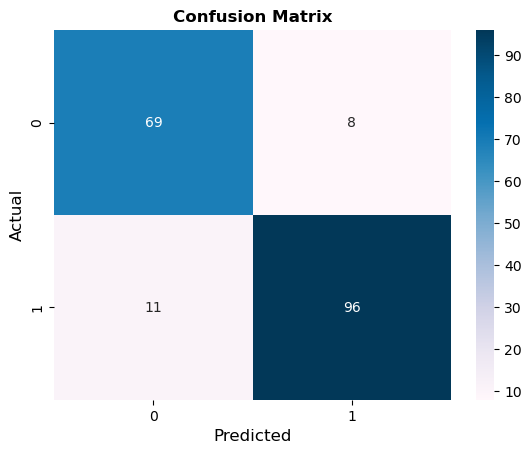

In [36]:
# Plot confusion matrix
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt='d', cmap='PuBu')
plt.title('Confusion Matrix', weight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12) ;

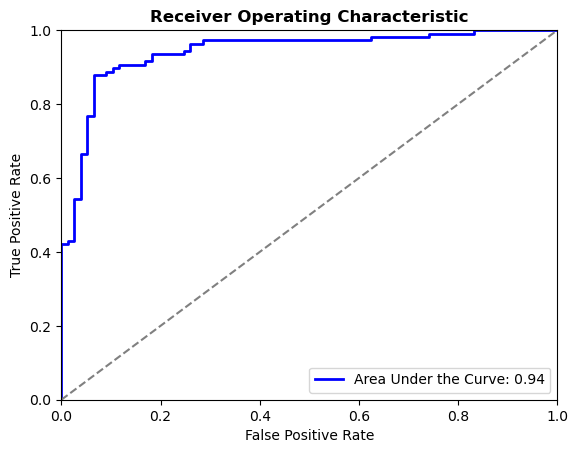

In [38]:
# ROC Curve - Visual representation of a classifier's performance at difference thresholds
probs = optimal_model.predict_proba(X_test)[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)

# Calculate Area under curve
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.plot(fpr, tpr, lw=2,label=f'Area Under the Curve:{roc_auc: .2f}', color='blue')
plt.plot([0,1],[0,1],linestyle='--', color='grey', lw=1.5)
plt.xlim([0, 1])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylim([0, 1])
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Receiver Operating Characteristic', weight='bold')
plt.legend();

In [40]:
# Save the model
model_path = os.path.join(os.path.dirname(os.getcwd()), 'models')

with open(os.path.join(model_path,'heart_failure_classifier.pkl'), 'wb') as f:
    pickle.dump(optimal_model, f) 